In [1]:
import numpy as np
import pandas as pd
import cv2,random
import matplotlib.pyplot as plt

In [2]:
test_vid=cv2.VideoCapture('./vids/2.mp4')

## Taking random frames inside of the video as test input

In [3]:
num_frames=50 # number of taken frames
ids_frame=random.sample(range(410),num_frames) # the taken frames will be in the range of 410 which is approximate 15s at 30FPS

In [4]:
frames_test={'index':[i for i in ids_frame] ,'frame':[]}

In [5]:
count=0
while True:
    ret,frame=test_vid.read()
    if not ret: break # End of file

    frame_rgb=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if count in frames_test['index']:
        
        frames_test['frame'].append(frame_rgb)
    
    # Uncomment to see the frames
    # plt.imshow(frame_rgb)
    # plt.title(f'Frame {count}')
    # plt.show()
    
    count+=1

In [6]:
print(f"There are {len(frames_test['frame'])} frames taken")

There are 50 frames taken


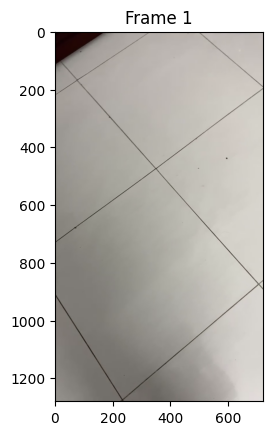

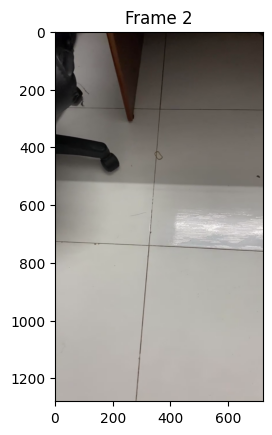

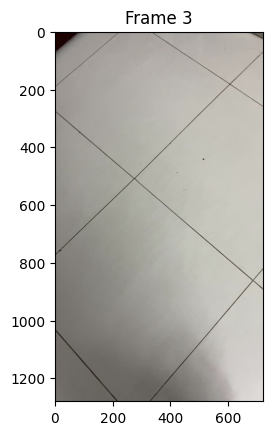

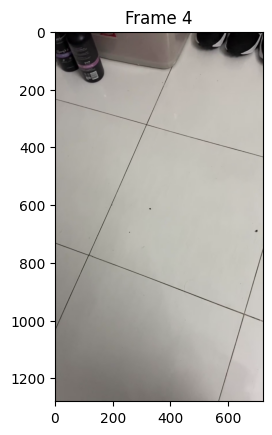

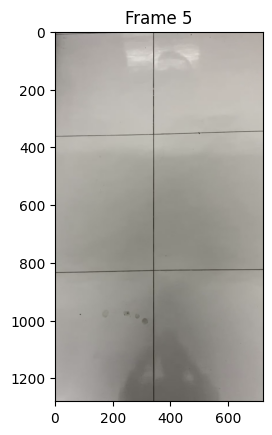

In [7]:
for pos,frame in enumerate(random.sample(frames_test['frame'],5)):
    plt.imshow(frame)
    plt.title(f'Frame {pos+1}')
    plt.show()

## Testing the calibrated function

In [8]:
from helpers import *
from calibrate import *

In [9]:
calib=Calibrate()

In [10]:
res_calib={'id':[],'frame':[],'log':[],'res':[]}


In [11]:
ids,frames = frames_test['index'],frames_test['frame']

for pos,frame in enumerate(frames):
    try:
        res_calib['id'].append(ids[pos])
        res_calib['frame'].append(frame)
        res,log=calib.update(frame)

        res_calib['log'].append(log)
        res_calib['res'].append(res)
        calib.update(frame)
    except:
        plt.imshow(frame)
        plt.title(f'Error frame {ids[pos]}')
        plt.show()

In [12]:
for i,log in enumerate(res_calib['log']):
    print(f'{i}: {log} -> {res_calib["res"][i]}')

0: <LOG> max_angle: 179.0 min_angle: 1.4166665077209473 ratio: 0.11517170430607945 taken_angle: 89.99999 -> (1.5707963, 0.11517170430607945)
1: <LOG> max_angle: 178.74998474121094 min_angle: 1.1666666269302368 ratio: 0.11817916545083162 taken_angle: 90.0 -> (1.5707964, 0.11817916545083162)
2: <LOG> max_angle: 178.3999786376953 min_angle: 1.1428570747375488 ratio: 0.08179811720192784 taken_angle: 89.79999 -> (1.5673056, 0.08179811720192784)
3: <LOG> max_angle: 178.14283752441406 min_angle: 0.555555522441864 ratio: 0.09151031205604272 taken_angle: 89.77778 -> (1.5669179, 0.09151031205604272)
4: <LOG> max_angle: 177.88888549804688 min_angle: 0.5714285373687744 ratio: 0.11031879194630873 taken_angle: 89.85713 -> (1.5683029, 0.11031879194630873)
5: <LOG> max_angle: 177.7777862548828 min_angle: 0.75 ratio: 0.09966145988002613 taken_angle: 90.0 -> (1.5707964, 0.09966145988002613)
6: <LOG> max_angle: 178.4285430908203 min_angle: 0.8333332538604736 ratio: 0.09202593561597087 taken_angle: 90.333

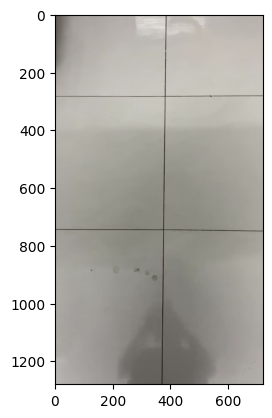

In [13]:
plt.imshow(frames[4])

The mathematic works by taking theta angle from Hough Transform process. Then the angle is normalized into the first y-axis or smaller than $\pi$. Therefore, we include a condition on `convert_angle()` function to normalized the given theta of each lines, `if theta>np.pi: theta-=np.pi`. Now, the angle is at one axis, we have to consider whether it is horizontal or vertical lines in our context; in our case, we want to take horizontal lines to get the angle device. So, to determine the horizontal angle, we want it to be $180^\circ \pm \text{acceptance angle}$, set to be $0.3 \pi$. Next, we have to consider what direction the car is facing to, choosing by considered $\text{angle} < \frac{\pi}{2} \text{:left} \land \text{angle} >\frac{\pi}{2} \text{:right}$

## Deciding the direction

In [14]:
failed={'pos':[],'theta':[]}
right={'pos':[],'theta':[]}
left={'pos':[],'theta':[]}
passed={'pos':[],'theta':[]}
acceptance_angle=0.1 # rad

for pos,res in enumerate(res_calib['res']):
    theta_a=res[0]
    print(f'Image number {pos}: Angle: {theta_a} Condition: ',end='')
    if theta_a is not None:
        if np.pi/2-acceptance_angle<theta_a and theta_a<acceptance_angle+np.pi/2:
            passed['pos'].append(pos)
            passed['theta'].append(theta_a)
            print('Passed.')
            continue

        if theta_a<np.pi/2:
            left['pos'].append(pos)
            left['theta'].append(theta_a)
            print('Left.')
            continue

        if theta_a>np.pi/2:
            right['pos'].append(pos)
            right['theta'].append(theta_a)
            print('Right.')
            continue

    failed['pos'].append(pos)
    failed['theta'].append(theta_a)
    print('Failed.')

Image number 0: Angle: 1.570796251296997 Condition: Passed.
Image number 1: Angle: 1.5707963705062866 Condition: Passed.
Image number 2: Angle: 1.567305564880371 Condition: Passed.
Image number 3: Angle: 1.566917896270752 Condition: Passed.
Image number 4: Angle: 1.568302869796753 Condition: Passed.
Image number 5: Angle: 1.5707963705062866 Condition: Passed.
Image number 6: Angle: 1.5766139030456543 Condition: Passed.
Image number 7: Angle: 1.574286937713623 Condition: Passed.
Image number 8: Angle: 1.5795228481292725 Condition: Passed.
Image number 9: Angle: 1.5620696544647217 Condition: Passed.
Image number 10: Angle: 1.67685866355896 Condition: Right.
Image number 11: Angle: 1.7011823654174805 Condition: Right.
Image number 12: Angle: 1.7278759479522705 Condition: Right.
Image number 13: Angle: 1.8481097221374512 Condition: Right.
Image number 14: Angle: None Condition: Failed.
Image number 15: Angle: None Condition: Failed.
Image number 16: Angle: None Condition: Failed.
Image num

In [15]:
np.rad2deg([res[0] for res in res_calib['res'] if res[0] is not None])

array([ 89.99999 ,  90.      ,  89.79999 ,  89.77778 ,  89.85713 ,
        90.      ,  90.33332 ,  90.19999 ,  90.499985,  89.49999 ,
        96.07692 ,  97.470566,  98.99999 , 105.88888 ,  90.      ,
        90.666664,  88.285706,  90.      ,  89.33333 ,  89.99999 ,
        91.59999 ,  87.99999 ,  87.99999 ,  89.5     ,  90.7     ,
        89.285706,  92.200005,  74.99999 ,  90.      ,  90.49999 ,
        91.99999 ,  74.5     ,  96.99999 ,  78.49999 ,  95.      ,
        98.49999 ,  98.5     ,  84.875   ,  88.93333 ,  88.85714 ,
        88.855064,  88.57143 ,  89.45454 ,  90.      ], dtype=float32)

In [16]:
np.rad2deg(acceptance_angle)

5.729577951308233

In [17]:
print(f'Number of pictures tilted right: {len(right["pos"])}')
print(f'Number of pictures tilted left: {len(left["pos"])}')
print(f'Number of pictures passed: {len(passed["pos"])}')
print(f'Number of pictures failed: {len(failed["pos"])}')
print(f'Total number of pictures: {len(res_calib["res"])}')

Number of pictures tilted right: 7
Number of pictures tilted left: 3
Number of pictures passed: 34
Number of pictures failed: 6
Total number of pictures: 50


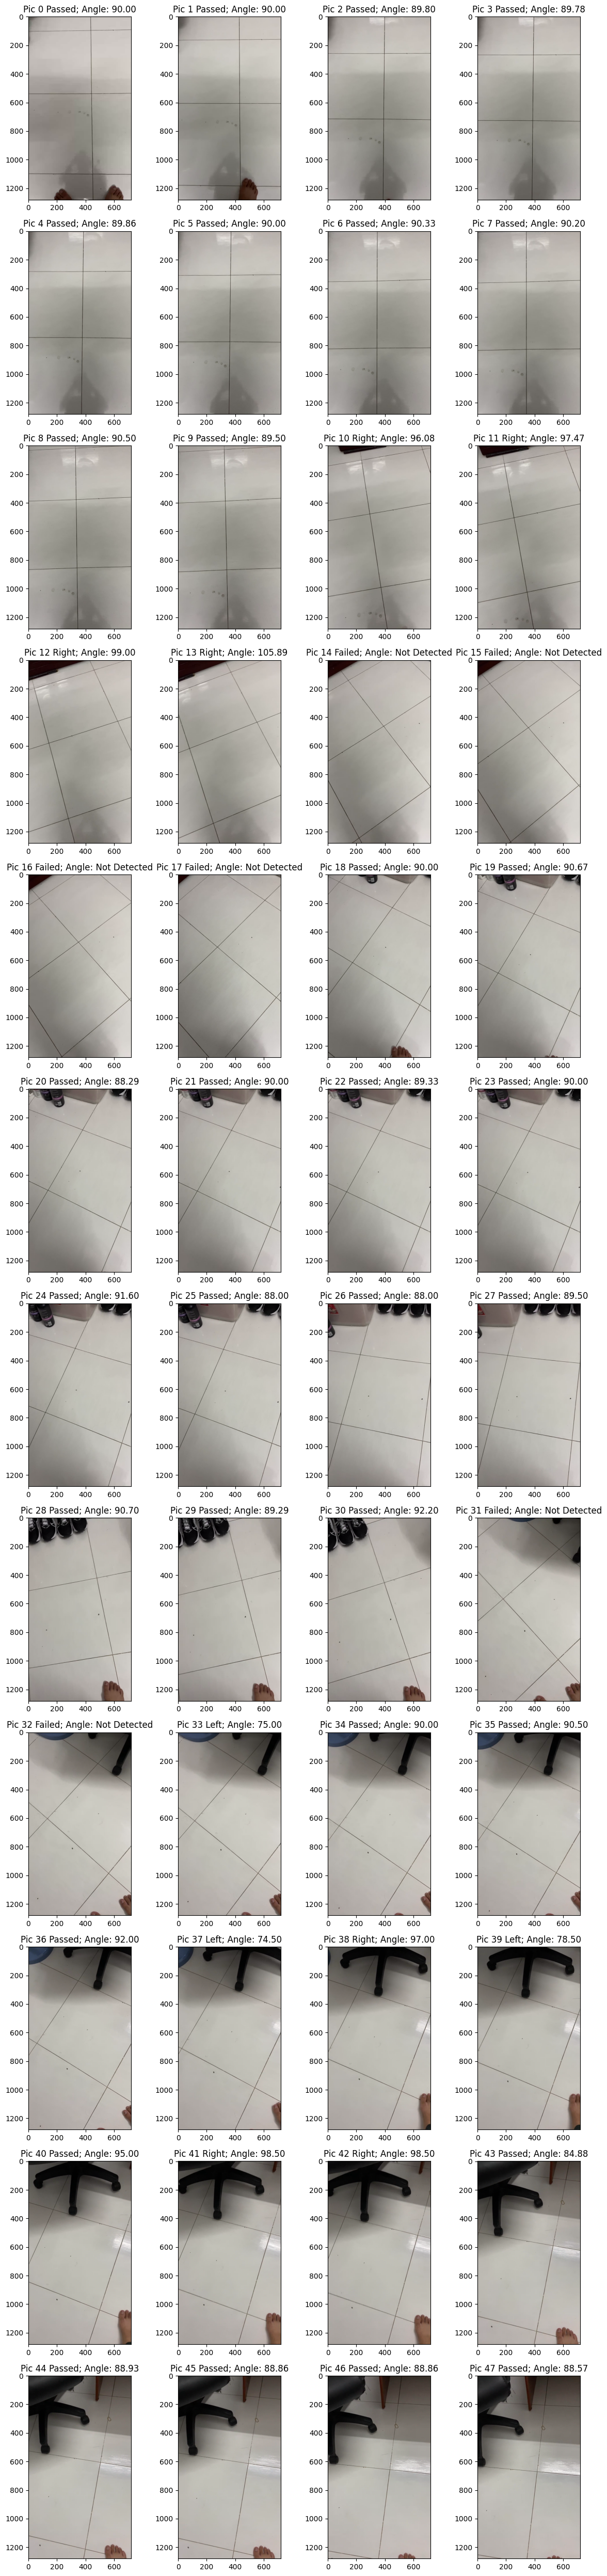

In [19]:
fig,axes=plt.subplots(num_frames//4,4,figsize=(num_frames//4,num_frames))
pos=0
for row in axes:
    for ax in row:
        ax.imshow(res_calib['frame'][pos])
        
        if pos in left['pos']: ax.set_title(f'Pic {pos} Left; Angle: {np.rad2deg(res_calib["res"][pos][0]):.2f}')
        if pos in right['pos']: ax.set_title(f'Pic {pos} Right; Angle: {np.rad2deg(res_calib["res"][pos][0]):.2f}')
        if pos in passed['pos']: ax.set_title(f'Pic {pos} Passed; Angle: {np.rad2deg(res_calib["res"][pos][0]):.2f}')
        if pos in failed['pos']: ax.set_title(f'Pic {pos} Failed; Angle: Not Detected')

        pos+=1
plt.tight_layout()
plt.show()

In [20]:
s,e=18,26
false_detect=res_calib['frame'][s:e]

In [31]:
from pid import PIDController